In [ ]:
#Task 1: Object Detection

import cv2
from ultralytics import YOLO


# Load YOLO model
model = YOLO("yolov8n.pt")

# Paths
inputVideoPath = "./videos/rawVideo.mp4"
outputVideoPath = "./videos/trackedcar.mp4"

# Open video
videoCaptureObject = cv2.VideoCapture(inputVideoPath)


# Get properties
frameWidth = int(videoCaptureObject.get(3))
frameHeight = int(videoCaptureObject.get(4))
framePerSec = int(videoCaptureObject.get(cv2.CAP_PROP_FPS))



# Set codec & output file
videoCodec = cv2.VideoWriter_fourcc(*"mp4v")  # More compatible
outputVideoObject = cv2.VideoWriter(outputVideoPath, videoCodec, framePerSec, (frameWidth, frameHeight))


carPosition = []
carStartingPosition = []
time = [0.3]
index = 0
while videoCaptureObject.isOpened():
    ret, frame = videoCaptureObject.read()
    if not ret:
        break

    # Process frame with YOLO
    framesResults = model(frame)

    for  frameResults in framesResults:
        for  box in frameResults.boxes:

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0].item()
            classId = int(box.cls[0])

            if  classId == 2 or classId == 5:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Yellow box
            #get the car starting position for the kalman filter

                if index == 0:

                    carStartingPosition.append([x1 + x2 / 2, y1 + y2 / 2])
                else :
                    carPosition.append([x1 + x2 / 2, y1 + y2 / 2])
                    if (len(carPosition) > 1):
                        time.append(time[-1] + 0.03)

                index = index + 1
    # Write frame
    outputVideoObject.write(frame)
    #cv2.imshow('Image Window', frame)

# Cleanup
#cv2.destroyAllWindows()
videoCaptureObject.release()
outputVideoObject.release()


print(f"Processed video saved at: {outputVideoPath}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/vscode/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 29.1MB/s]



0: 640x384 1 train, 100.5ms
Speed: 7.5ms preprocess, 100.5ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 1 train, 45.8ms
Speed: 3.0ms preprocess, 45.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 1 train, 41.3ms
Speed: 1.1ms preprocess, 41.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 41.1ms
Speed: 1.5ms preprocess, 41.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 40.4ms
Speed: 1.4ms preprocess, 40.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 46.5ms
Speed: 1.4ms preprocess, 46.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 41.5ms
Speed: 1.6ms preprocess, 41.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 46.0ms
Speed: 1.3ms preprocess, 46.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640,

[[533.0, 1191.5]]


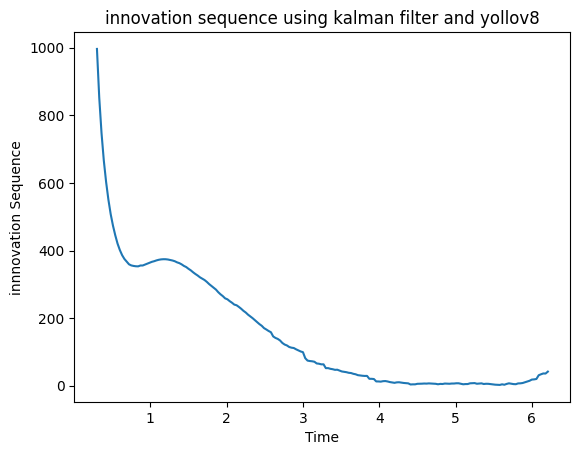

In [ ]:
#Task 2: Kalman Filter
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import math
# Time step (seconds)
dt = 0.03

print(carStartingPosition)
# Initialize Kalman Filter (4 state variables: x, vx, y, vy)
kf = KalmanFilter(dim_x=4, dim_z=2)

# State transition matrix (constant velocity model)
kf.F = np.array([[1, dt, 0, 0],  # x' = x + vx * dt
                 [0, 1, 0, 0],   # vx' = vx
                 [0, 0, 1, dt],  # y' = y + vy * dt
                 [0, 0, 0, 1]])  # vy' = vy

# Measurement matrix (we only measure position, not velocity)
kf.H = np.array([[1, 0, 0, 0],  # we measure x position
                 [0, 0, 1, 0]])  # we measure y position

# Initial state estimate: position (0, 0), velocity (0, 0)
kf.x = np.array([carStartingPosition[0][0], carStartingPosition[0][1], 0, 0])

# Initial covariance matrix (high uncertainty in the initial state)
kf.P = np.eye(4) * 1

# Process noise covariance matrix using the built-in function (4-state system)
kf.Q = Q_discrete_white_noise(dim=4, dt=dt, var=0.13)

# Measurement noise covariance matrix (assuming some measurement noise in x and y)
kf.R = np.array([[5, 0],
                 [0, 5]])

innovationSequence = []

# Running the Kalman filter on the measurements
for z in carPosition:
    kf.predict()  # Predict the next state
    kf.update(z)  # Update the state with the new measurement
    innovationSequence.append(math.sqrt((kf.x[0] - z[0])**2 + (kf.x[2] - z[1])**2))


plt.plot(time, innovationSequence)
plt.xlabel('Time')
plt.ylabel('innnovation Sequence')
plt.title('innovation sequence using kalman filter and yollov8')
plt.show()

In [ ]:
#Task 3: Count Vehicular Traffic
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# Load YOLOv8 model
model = YOLO('../runs/detect/train/weights/best.pt')

# Initialize DeepSORT
deepsort = DeepSort(max_age=30, n_init=3)

# Open video file
video_path = "./videos/trafficCount.mp4"
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_rate = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_duration = frame_count / frame_rate

# Get video dimensions
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define output video writer
output_path = 'output_video_deepsort.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height))

# Initialize vehicle counters
count_direction_1 = 0
count_direction_2 = 0
tracked_objects = {}
mid_x = frame_width // 2
GREEN = (0, 255, 0)  # BGR format (Green)
WHITE = (255, 255, 255)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # YOLO detection
    results = model(frame)
    detections = []

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(float, box.xyxy[0])  # Keep as float for DeepSORT
            conf = float(box.conf)
            class_id = int(box.cls)

            if class_id in [2, 3, 5, 7] and conf > 0.5:  # Vehicles only
                # Format: [[x1, y1, x2, y2], confidence]
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
                detections.append([[x1, y1, x2, y2], conf, class_id])

    # Update DeepSORT tracker
    tracks = deepsort.update_tracks(detections, frame=frame)

    # Visualize and count
    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        ltrb = track.to_ltrb()  # Get [x1, y1, x2, y2]
        center_x = int((ltrb[0] + ltrb[2]) / 2)

        # Draw bounding box
        # cv2.rectangle(frame,
        #              (int(ltrb[0]), int(ltrb[1])),
        #              (int(ltrb[2]), int(ltrb[3])),
        #              (0, 255, 0), 2)

        # # Draw track ID
        # cv2.putText(frame, f"ID {track_id}",
        #            (int(ltrb[0]), int(ltrb[1])-10),
        #            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
        xmin, ymin, xmax, ymax = int(ltrb[0]), int(ltrb[1]), int(ltrb[2]), int(ltrb[3])
        # Draw the bounding box and the track ID on the frame
        # cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), GREEN, 2)
        # cv2.rectangle(frame, (xmin, ymin - 20), (xmin + 20, ymin), GREEN, -1)
        cv2.putText(frame, str(track_id), (xmin + 5, ymin - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, WHITE, 2)

        # Count direction crossings
        if track_id not in tracked_objects:
            tracked_objects[track_id] = center_x
        else:
            if tracked_objects[track_id] < mid_x and center_x >= mid_x:
                count_direction_1 += 1
            elif tracked_objects[track_id] >= mid_x and center_x < mid_x:
                count_direction_2 += 1
            tracked_objects[track_id] = center_x

    # Display counts
    cv2.putText(frame, f"Direction 1: {count_direction_1}", (50, 50),
               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    cv2.putText(frame, f"Direction 2: {count_direction_2}", (50, 100),
               cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

    out.write(frame)



cap.release()
out.release()

print(f"Processed video saved as: {output_path}")


0: 384x640 10 cars, 4 vans, 1 truck, 65.3ms
Speed: 8.2ms preprocess, 65.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 8 vans, 1 truck, 46.2ms
Speed: 1.6ms preprocess, 46.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 4 vans, 1 truck, 50.9ms
Speed: 1.3ms preprocess, 50.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 5 vans, 1 truck, 50.3ms
Speed: 1.3ms preprocess, 50.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 7 vans, 2 trucks, 44.1ms
Speed: 1.2ms preprocess, 44.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 7 vans, 2 trucks, 51.7ms
Speed: 2.0ms preprocess, 51.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 8 vans, 2 trucks, 49.1ms
Speed: 1.8ms preprocess, 49.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x

In [ ]:
from ultralytics import YOLO

# Load a pretrained model and train it on your custom dataset
model = YOLO("yolo11n.pt")  # Load a pretrained YOLO model

# Train the model
model.train(data="VisDrone.yaml", epochs=20, imgsz=640)  # Train for 20 epochs
